In [1]:
# Set paths
idmap_train_dir = '../data/input/trainmap.csv'
methy_train_dir = '../data/input/traindata.csv'
idmap_test_dir = '../data/input/testmap.csv'
methy_test_dir = '../data/input/testdata.csv'
output_dir = "../data/output/"

In [2]:
import pandas as pd
import h5py

# Save data as HDF5 files
def save_file_h5(methy_dir, chunk_size, name):
    df_chunks = pd.read_csv(methy_dir,
                            sep=',',
                            index_col=0,
                            chunksize=chunk_size)

    with h5py.File(name, 'w') as file:
        total_cols = 0
        for i, chunk in enumerate(df_chunks):
            chunk = chunk.transpose()
            chunk = chunk.fillna(0)
            data_array = chunk.to_numpy()
            chunk_cols = data_array.shape[1]
            if i == 0:
                samples_num = data_array.shape[0]
                dataset = file.create_dataset('data',
                                              shape=data_array.shape,
                                              maxshape=(samples_num, None))

            dataset.resize((dataset.shape[0], total_cols + chunk_cols))
            dataset[:, total_cols:total_cols + chunk_cols] = data_array
            total_cols += chunk_cols

    return None

In [3]:
create_h5 = False

# Save data
if create_h5:
    chunk_size = 5000

    save_file_h5(methy_train_dir, chunk_size, output_dir + 'train.h5')
    print('Train data saved.')

    save_file_h5(methy_test_dir, chunk_size, output_dir + 'test.h5')
    print('Test data saved.')

In [4]:
import numpy as np

# Load idmap data from .csv file
def load_idmap_csv(file):
    sample_type_mapping = {'control': 0, 'disease tissue': 1}
    
    idmap = pd.read_csv(file, sep=',')
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    sample_type = idmap.sample_type.replace(sample_type_mapping)
    
    return age, sample_type

# Load methylation data from .h5 file. 
def load_methylation_h5(file, rows=None):
    methylation = h5py.File(file, 'r')['data']
    h5py.File(file, 'r').close()

    if rows != None:
        return methylation[:, :rows]
    else:
        return methylation[:, :]

In [5]:
from sklearn.linear_model import ElasticNet

# Train linear regression model
def train_ml(X_train, y_train):
    model = ElasticNet()
    model.fit(X_train, y_train)
    return model

# Evaluate model
def evaluate_ml(mode, y_true, y_pred, sample_type):
    if mode == 'MSE':
        mse_control = np.mean((y_true[sample_type == 0] - y_pred[sample_type == 0]) ** 2)

        case_true = y_true[sample_type == 1]
        case_pred = y_pred[sample_type == 1]
        above = np.where(case_pred >= case_true)
        below = np.where(case_pred < case_true)

        se_above = np.sum((case_true[above] - case_pred[above]) ** 2) / 2
        se_below = np.sum((case_true[below] - case_pred[below]) ** 2)
        mse_case = (se_above + se_below) / len(case_true)

        mse = np.mean([mse_control, mse_case])

        return mse, mse_control, mse_case

    elif mode == 'MAE':
        mae_control = np.mean(np.abs(y_true[sample_type == 0] - y_pred[sample_type == 0]))

        case_true = y_true[sample_type == 1]
        case_pred = y_pred[sample_type == 1]
        above = np.where(case_pred >= case_true)
        below = np.where(case_pred < case_true)

        ae_above = np.sum(np.abs(case_true[above] - case_pred[above])) / 2
        ae_below = np.sum(np.abs(case_true[below] - case_pred[below]))
        mae_case = (ae_above + ae_below) / len(case_true)

        mae = np.mean([mae_control, mae_case])
        return mae, mae_control, mae_case


In [23]:
# Load idmap
age, sample_type = load_idmap_csv(idmap_train_dir)
print("ID map loaded.")

age_train = age[:5000]
age_test = age[5000:]

print("age_train shape:", age_train.shape)
print("age_test shape:",age_test.shape)

sample_train = sample_type[:5000]
sample_test = sample_type[5000:]

print("sample_train shape:", sample_train.shape)
print("sample_test shape:",sample_test.shape)

# Load methylation data
methylation_data = load_methylation_h5('../data/input/train.h5')
print("\nMethylation data loaded.")

train_data = methylation_data[:5000]
test_data = methylation_data[5000:]

print("methylation_train shape:", train_data.shape)
print("methylation_test shape:", test_data.shape)

ID map loaded.
age_train shape: (5000,)
age_test shape: (3233,)
sample_train shape: (5000,)
sample_test shape: (3233,)

Methylation data loaded.
methylation_train shape: (5000, 485512)
methylation_test shape: (3233, 485512)


In [24]:
from sklearn.model_selection import train_test_split
import random

random.seed(42)

# Split data into training and validation sets
indices = np.arange(sample_train.shape[0])
[indices_train, indices_valid, age_train, age_valid] = train_test_split(indices, age_train, test_size=0.3, shuffle=True)

methylation_train = train_data[indices_train]
methylation_valid = train_data[indices_valid]

sample_type_train = sample_train[indices_train]
sample_type_valid = sample_train[indices_valid]

feature_size = methylation_train.shape[1]


In [25]:
import time
import pickle

# Train new model
train_model = True

# Model path
model = '../data/output/model.pkl'

if train_model:
    # Train data
    print('Training started.')
    start = time.time()
    pred_model = train_ml(methylation_train, age_train)
    print(f'Training time: {time.time() - start}s')

    # Save model to pkl
    model_filename = "../data/output/model.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(pred_model, model_file)
    print(f'Model saved to {model_filename}')
else:
    # Load model
    with open(model, 'rb') as model_file:
        pred_model = pickle.load(model_file)
    print(f'{model} loaded.')

# Evaluate model
evaluation_mode = 'MAE'

age_valid_pred = pred_model.predict(methylation_valid)
age_valid_eval = evaluate_ml(evaluation_mode, age_valid, age_valid_pred, sample_type_valid)
print(f'Validation {evaluation_mode}: {age_valid_eval}')

age_test_pred = pred_model.predict(test_data)
age_test_eval = evaluate_ml(evaluation_mode, age_test, age_test_pred, sample_test)
print(f'Test {evaluation_mode}: {age_test_eval}')

# Post-processing to ensure age >= 0
age_valid_pred[age_valid_pred < 0] = 0  
age_test_pred[age_test_pred < 0] = 0  


Training started.


/Users/jkatyan/Documents/conda/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.857e+03, tolerance: 2.926e+02
  model = cd_fast.enet_coordinate_descent(


Training time: 34220.06362104416s
Model saved to ../data/output/model.pkl
Validation MAE: (4.641817227747645, 5.176823, 4.106811316304617)
Test MAE: (6.072213893208078, 6.8682337, 5.276194105691057)


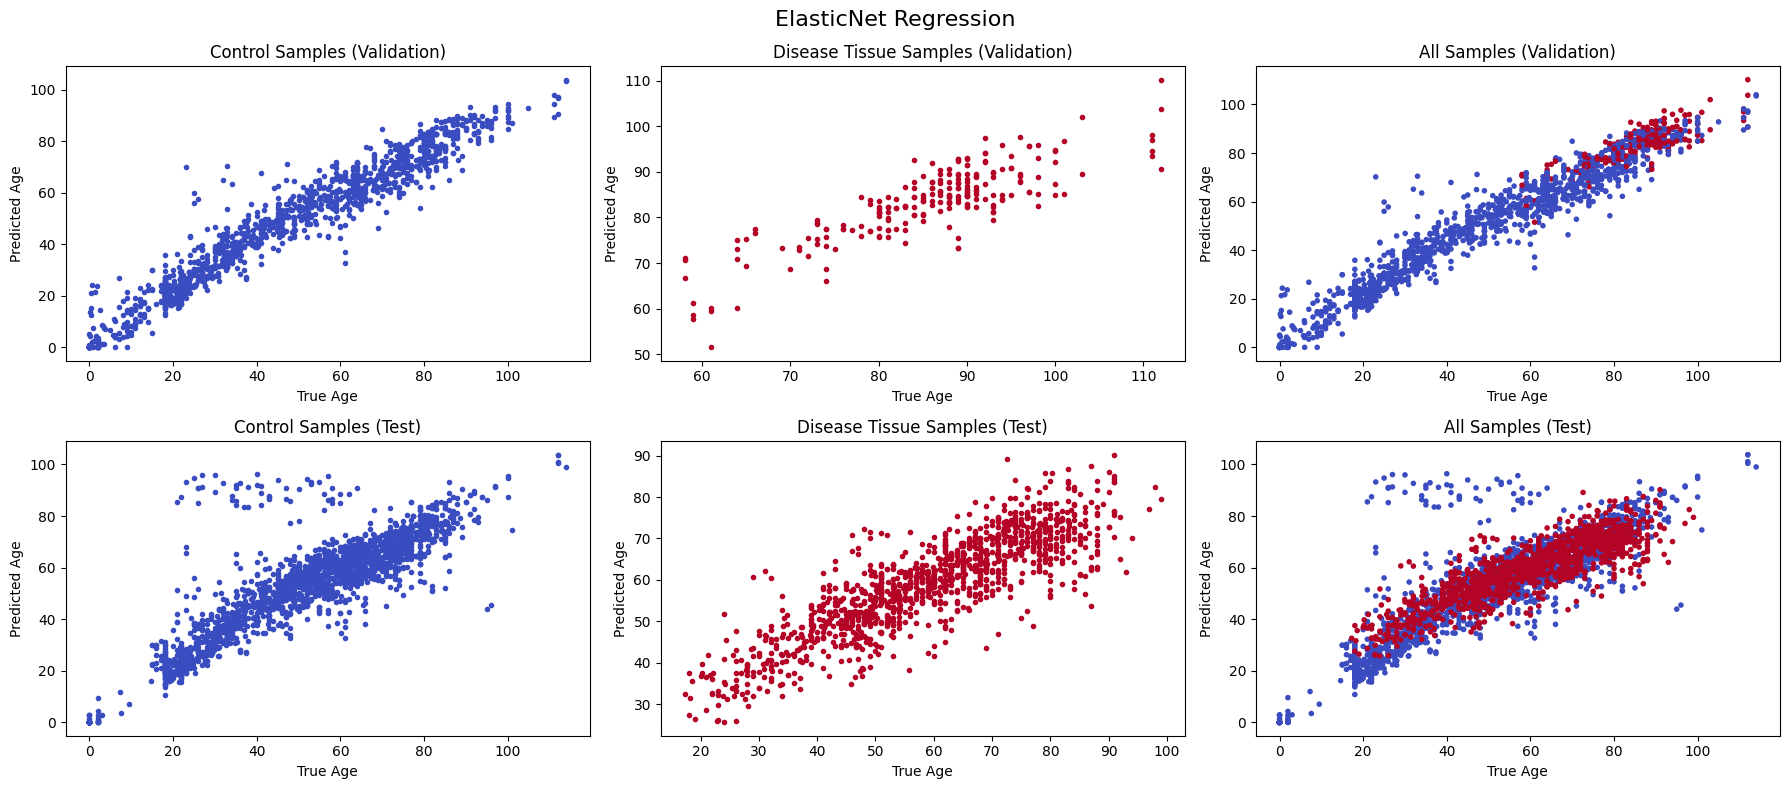

In [43]:
import matplotlib.pyplot as plt

# Separate data for control and disease tissue samples in the validation set
control_valid_mask = sample_type_valid == 0
disease_valid_mask = sample_type_valid == 1

# Separate data for control and disease tissue samples in the test set
control_test_mask = sample_test == 0
disease_test_mask = sample_test == 1

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Set title
plt.suptitle("ElasticNet Regression", fontsize=16)

# Plot the graphs for the validation set
axes[0, 0].scatter(age_valid[control_valid_mask], age_valid_pred[control_valid_mask], marker='.', c='#3a4dc0')
axes[0, 0].set_xlabel('True Age')
axes[0, 0].set_ylabel('Predicted Age')
axes[0, 0].set_title('Control Samples (Validation)')

axes[0, 1].scatter(age_valid[disease_valid_mask], age_valid_pred[disease_valid_mask], marker='.', c='#b40326')
axes[0, 1].set_xlabel('True Age')
axes[0, 1].set_ylabel('Predicted Age')
axes[0, 1].set_title('Disease Tissue Samples (Validation)')

axes[0, 2].scatter(age_valid, age_valid_pred, marker='.', c=sample_type_valid, cmap=plt.cm.coolwarm)
axes[0, 2].set_xlabel('True Age')
axes[0, 2].set_ylabel('Predicted Age')
axes[0, 2].set_title('All Samples (Validation)')

# Plot the graphs for the test set
axes[1, 0].scatter(age_test[control_test_mask], age_test_pred[control_test_mask], marker='.', c='#3a4dc0')
axes[1, 0].set_xlabel('True Age')
axes[1, 0].set_ylabel('Predicted Age')
axes[1, 0].set_title('Control Samples (Test)')

axes[1, 1].scatter(age_test[disease_test_mask], age_test_pred[disease_test_mask], marker='.', c='#b40326')
axes[1, 1].set_xlabel('True Age')
axes[1, 1].set_ylabel('Predicted Age')
axes[1, 1].set_title('Disease Tissue Samples (Test)')

axes[1, 2].scatter(age_test, age_test_pred, marker='.', c=sample_test, cmap=plt.cm.coolwarm)
axes[1, 2].set_xlabel('True Age')
axes[1, 2].set_ylabel('Predicted Age')
axes[1, 2].set_title('All Samples (Test)')

plt.tight_layout()
plt.show()
